<a name = "topp"></a>
# Numbers Applications
- [Spectral](#spect)
- [Mel Spectral](#melspec)
- [Clusters](#clustmel)
- [Heatmap](#heat)

In [1]:
from sound_info import * # our custom made tools under construction 

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import sklearn.cluster
from sklearn.cluster import KMeans
import pandas as pd
import pydub
import IPython.display
import statistics
from pydub import AudioSegment
from pydub.playback import play
from itertools import groupby
from operator import itemgetter



In [2]:



def gaussMachine(message, noiseVol = 0, export = False, name = "trial.wav"): # add gaussian noise
    messLength = message.duration_seconds
    gaussLength = gauss.duration_seconds
    if messLength >= gaussLength: # matching the length of noise to the length of message
        gauss1 = (gauss * math.ceil(messLength/gaussLength))[0:messLength*1000] + noiseVol # adjustable volume for the noise
    else:
        gauss1 = gauss[0:messLength*1000] + noiseVol
    combo = message.overlay(gauss1)
    if export == True:
        combo.export(out_f = name)
        return(combo)    
    return(combo)
    
def noiseMachine(message, noiseVol = 0, export = False, name = "trial.wav"): # layers every background noise, a possible future upgrade would allow selection of noises
    messLength = message.duration_seconds
    trafficLength = traffic.duration_seconds
    voiceLength = voice.duration_seconds
    crossLength = crossing.duration_seconds
    noiseMix = traffic.overlay((
        (voice * math.ceil(trafficLength/voiceLength))[0:trafficLength*1000] + 10).overlay(
        crossing * math.ceil(trafficLength/crossLength))[0:trafficLength*1000] + 20) + noiseVol # creates a standard mix of noise
    noiseMixLength = noiseMix.duration_seconds
    if messLength >= noiseMixLength:
        noiseMix = (noiseMix * math.ceil(messLength/noiseMixLength))[0:messLength*1000] # loops noise mix and cuts it at the end of the message
    combo = message.overlay(noiseMix[0:messLength*1000])
    if export == True:
        combo.export(out_f = name)
        return(combo)
    return(combo)

In [3]:
### Import Noises ###

os.chdir(r"C:\Users\tanse\Desktop\auditoryLab\noises")

gauss = AudioSegment.from_file("gauss.wav", format = "wav")
traffic = AudioSegment.from_file("traffic.wav", format = "wav")
voice = AudioSegment.from_file("voices.wav", format = "wav")
crossing = AudioSegment.from_file("crossing.wav", format = "wav")

numbers = AudioSegment.from_file("numbers.wav", format = "wav")


In [4]:
noiseMachine(numbers, -30, export = True, name = "trial2.wav")

In [5]:
dataN, rateN = librosa.load("trial.wav")
data, rate = librosa.load("numbers.wav")

data2, rate2 = librosa.load("trial2.wav")

C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [6]:
h_window_size, h_step, h_bins = get_default_params()


<a name = "spect"></a>
## Spectral
[Top](#topp)

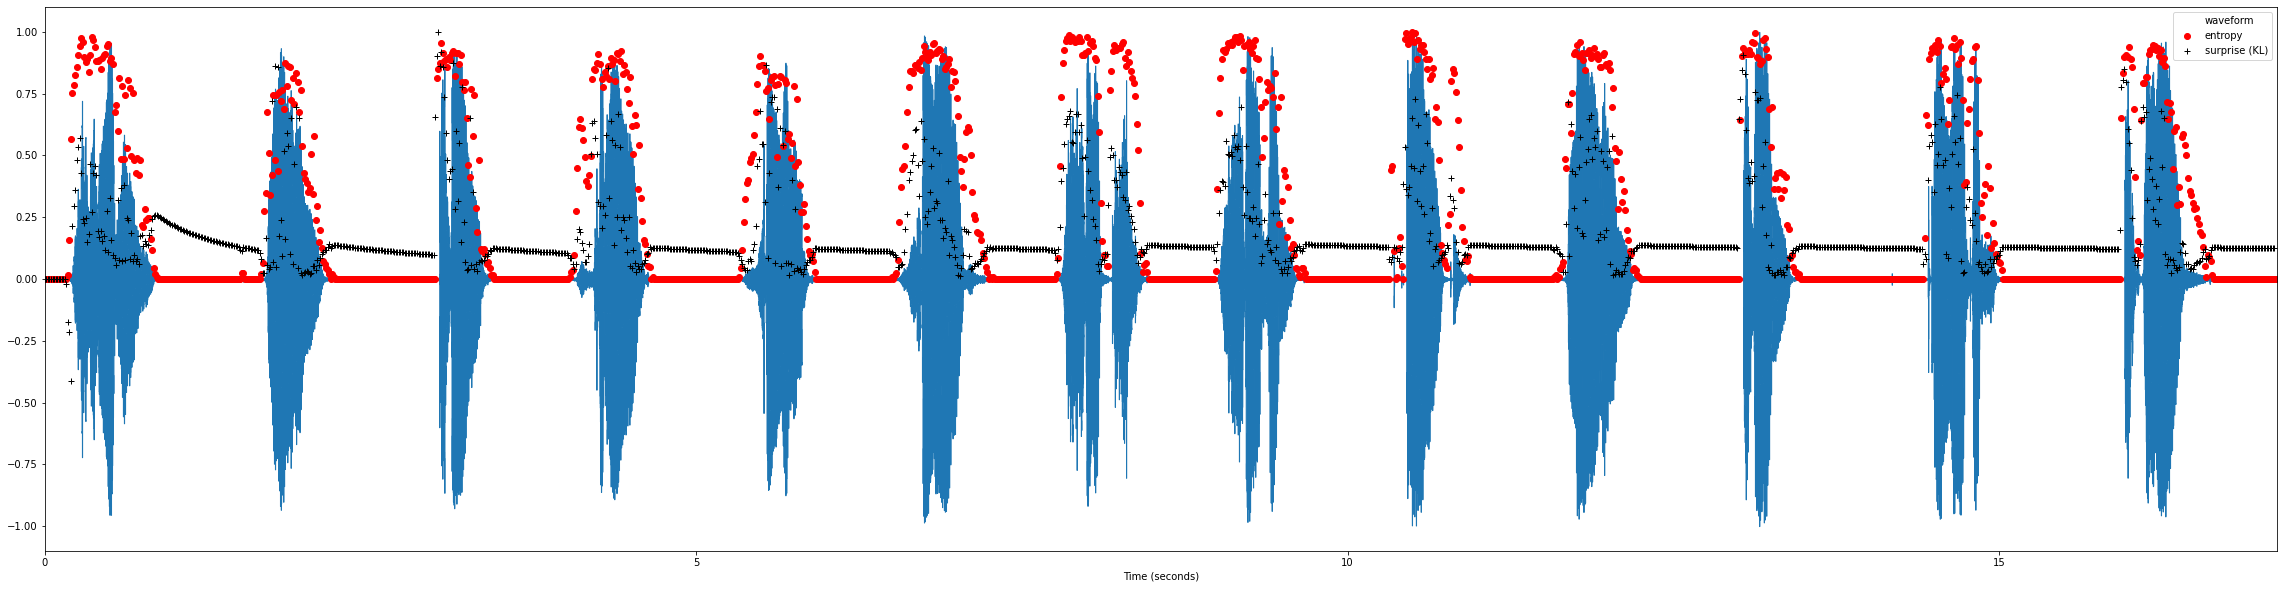

Wall time: 2.68 s


In [7]:
%%time


steps = stepper(data, rate, window_size = h_window_size, step_size = h_step)
spc_power, tst = log_spectral_power(steps)
probs = prob_calc(spc_power, binNum = h_bins)
h = entropy_calc(probs)
kl = kl_calc(probs)

plt.figure(figsize = (40,10))
librosa.display.waveshow(y = data/np.max(np.abs(data)), sr = rate)
plt.plot(np.arange(0,len(h))/(rate/h_step), h/np.max(h), 'ro')
plt.plot(np.arange(0,len(kl))/(rate/h_step), kl/np.nanmax(np.abs(kl)), 'k+')
plt.legend(['waveform', 'entropy', 'surprise (KL)'])
plt.xlabel("Time (seconds)")

plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

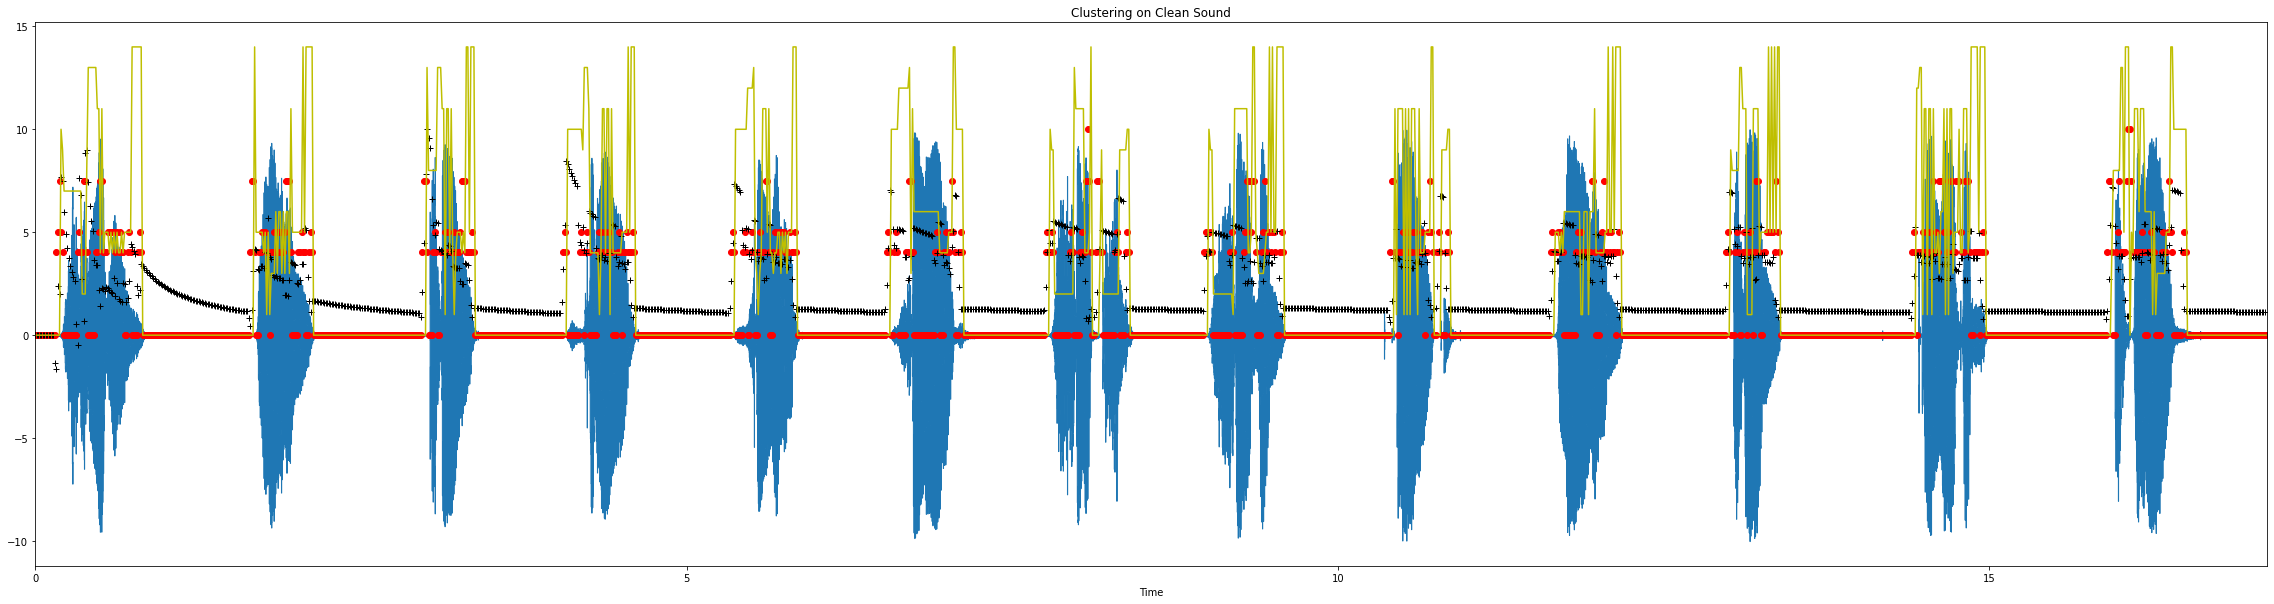

In [8]:
# Clustering on Spectral to make sure mel spectral working properly
result = KMeans(n_clusters = 15, random_state = 0).fit(spc_power)
steps = stepper(result.labels_, rate = 16, step_size = 1, window_size = 4)
probs = prob_calc(steps, binNum = h_bins)
h = entropy_calc(probs)
kl = kl_calc(probs)

plt.figure(figsize = (40,10))
plt.title("Clustering on Clean Sound")
librosa.display.waveshow(y = 10*data/np.max(np.abs(data)), sr = rate)
plt.plot(np.arange(0,len(h))/(rate/h_step), 10*h/np.max(h), 'ro')
plt.plot(np.arange(0,len(kl))/(rate/h_step), 10*kl/np.nanmax(np.abs(kl)), 'k+')
plt.autoscale(enable=True, axis='x', tight=True)
plt.plot(np.arange(0,len(h))/(rate/h_step), result.labels_, 'y')

<a name = "melspec" a></a>
## Mel Spectrogram
[Top](#topp)

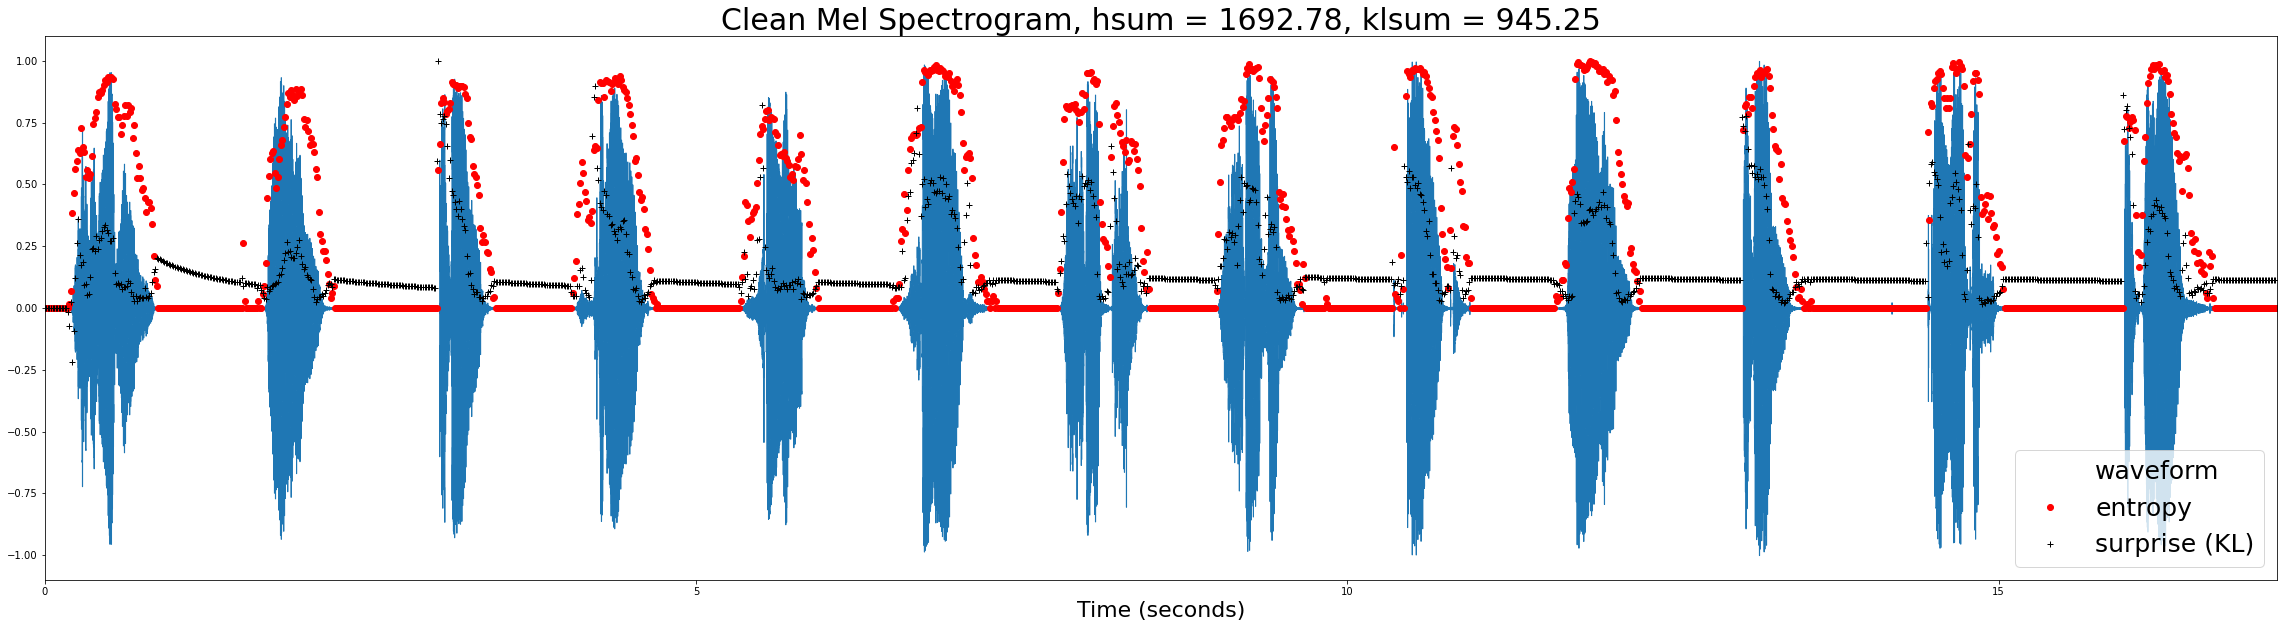

In [9]:
mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=2048, hop_length=h_step, win_length=h_window_size)
mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60) 
probs = prob_calc(mel_spc_db.T, binNum = h_bins)
h = entropy_calc(probs)
kl = kl_calc(probs)

hsum = np.sum(h)
klsum = np.sum(kl)

# plt.figure(figsize=(40, 10))
# librosa.display.specshow(mel_spc_db, y_axis='mel', fmax=8000, x_axis='time');
# plt.title('Mel Spectrogram', fontsize = 30);
# plt.xlabel('Time', fontsize=22)
# plt.ylabel('Mel', fontsize=22)


plt.figure(figsize = (40,10))
librosa.display.waveshow(y = data/np.max(np.abs(data)), sr = rate)
plt.plot(np.arange(0,len(h))/(rate/h_step), h/np.max(h), 'ro')
plt.plot(np.arange(0,len(kl))/(rate/h_step), kl/np.nanmax(np.abs(kl)), 'k+')
plt.legend(['waveform', 'entropy', 'surprise (KL)'], fontsize = 25)
plt.xlabel("Time (seconds)", fontsize = 22)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Clean Mel Spectrogram, hsum = {}, klsum = {}".format(np.round(hsum, 2), np.round(klsum, 2)), fontsize = 30)
plt.show()



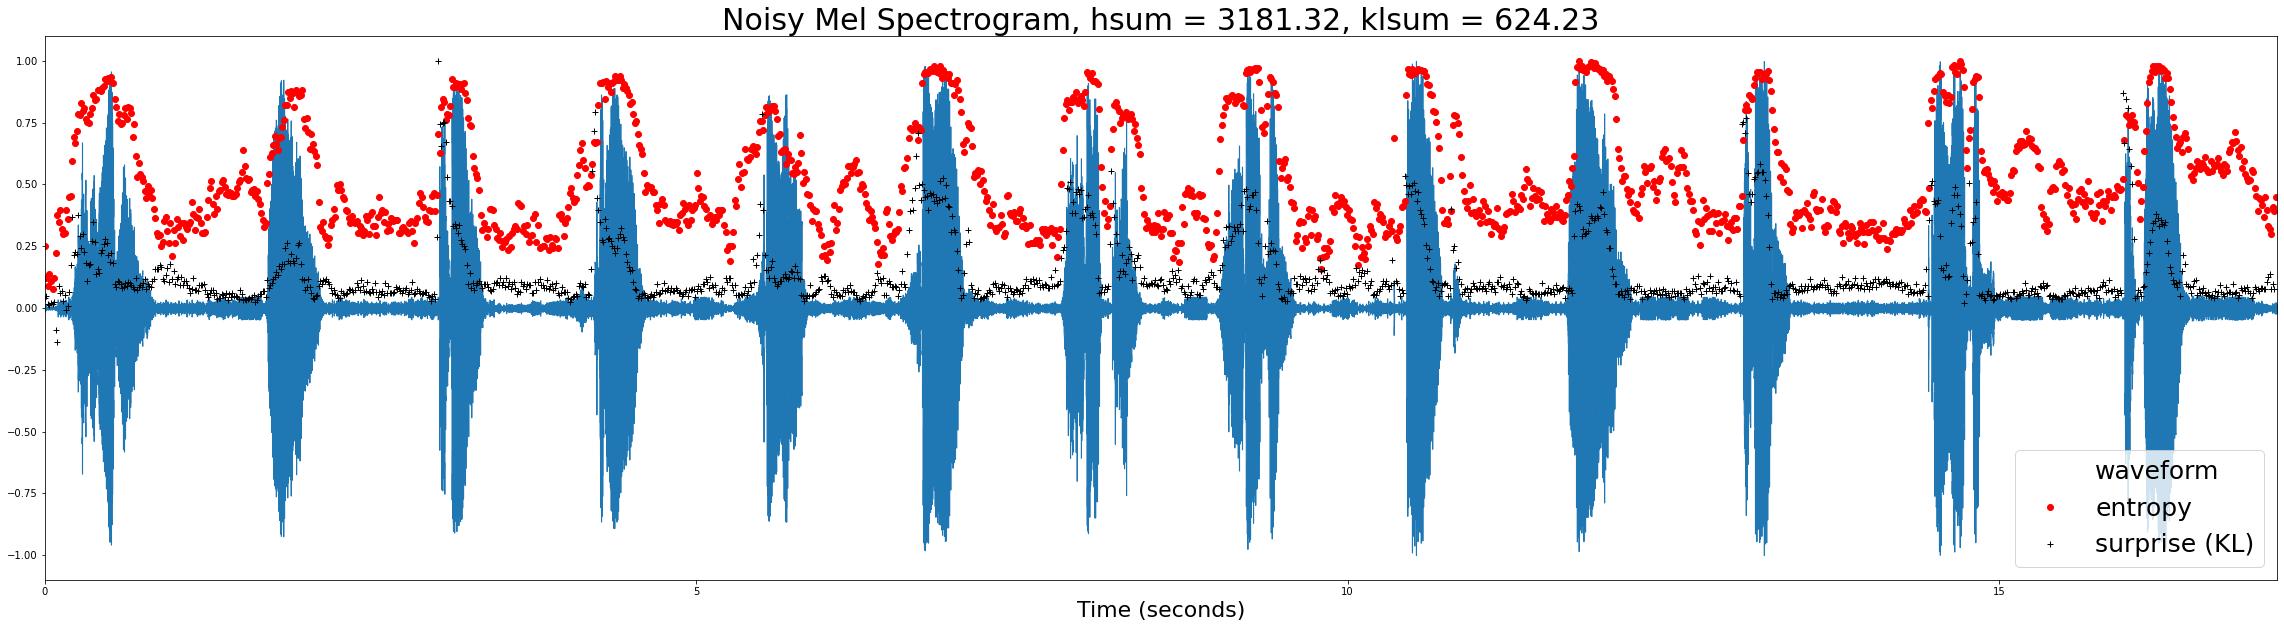

In [10]:
mel_spc2 = librosa.feature.melspectrogram(y=data2, sr=rate2, n_fft=2048, hop_length=h_step, win_length=h_window_size)
mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60) 
probs2 = prob_calc(mel_spc_db2.T, binNum = h_bins)
h2 = entropy_calc(probs2)
kl2 = kl_calc(probs2)

h2sum = np.sum(h2)
kl2sum = np.sum(kl2)

# plt.figure(figsize=(40, 10))
# librosa.display.specshow(mel_spc_db2, y_axis='mel', fmax=8000, x_axis='time');
# plt.title('Noisy Mel Spectrogram', fontsize = 30);
# plt.xlabel('Time', fontsize=22)
# plt.ylabel('Mel', fontsize=22)
plt.figure(figsize = (40,10))
librosa.display.waveshow(y = data2/np.max(np.abs(data2)), sr = rate2)
plt.plot(np.arange(0,len(h2))/(rate2/h_step), h2/np.max(h2), 'ro')
plt.plot(np.arange(0,len(kl2))/(rate2/h_step), kl2/np.nanmax(np.abs(kl2)), 'k+')
# plt.plot(np.arange(0,len(kl))/(rate/h_step), kl/np.nanmax(np.abs(kl)), 'yx')

plt.legend(['waveform', 'entropy', 'surprise (KL)'], fontsize = 25)
plt.xlabel("Time (seconds)", fontsize = 22)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Noisy Mel Spectrogram, hsum = {}, klsum = {}".format(np.round(h2sum, 2), np.round(kl2sum, 2)), fontsize = 30)
plt.show()

<a name = "clustmel" a></a>
### Clustering on Mel Spectrograms
[Top](#topp)
- Entropy and KL divergence calculations performed on the clustering labels


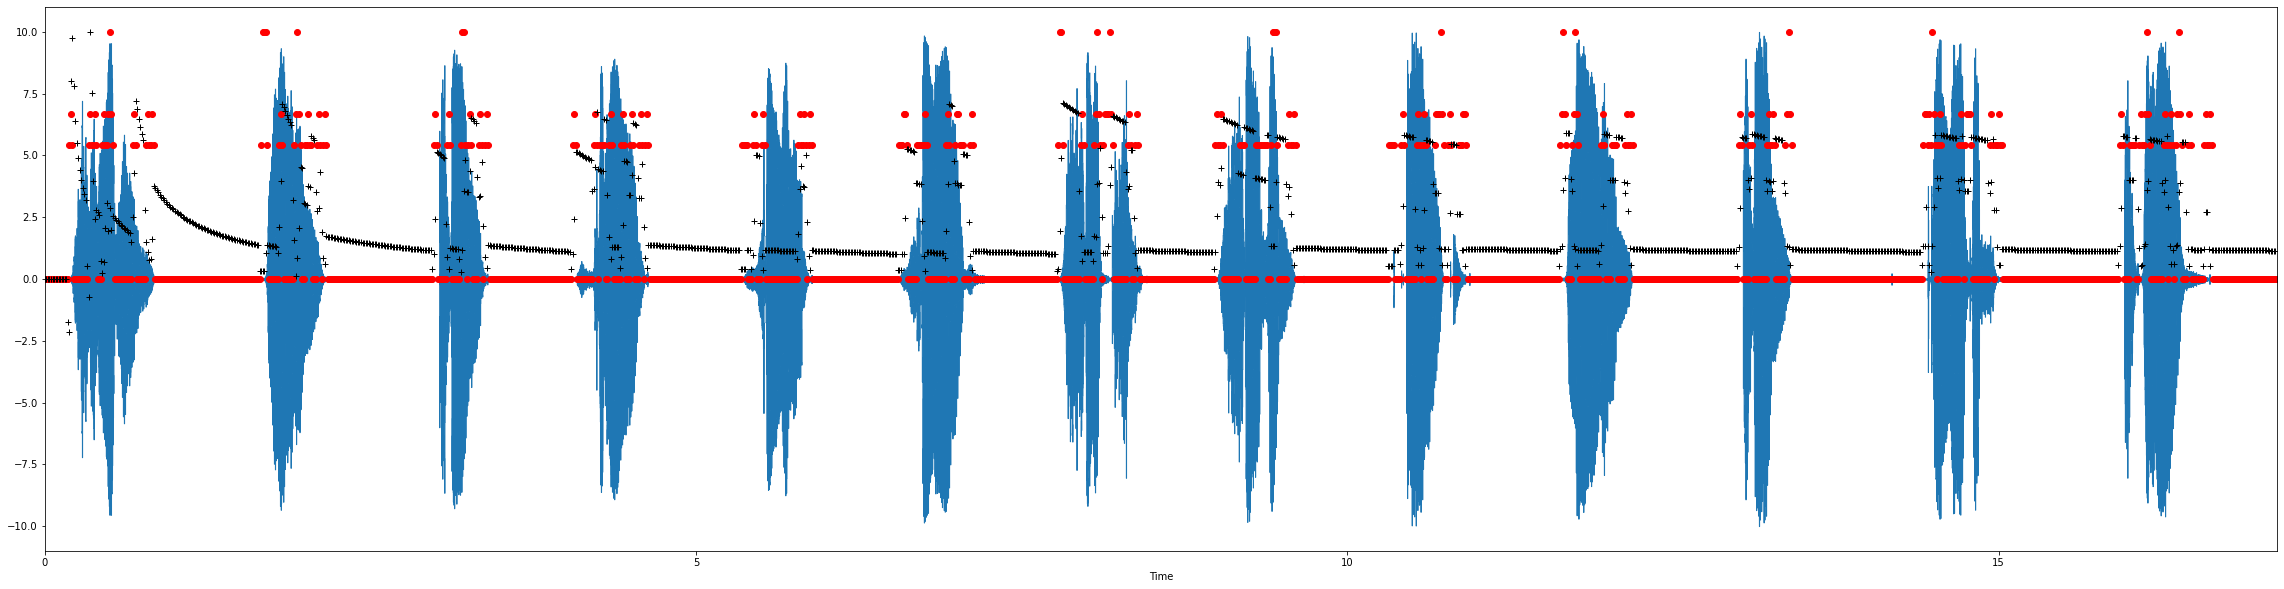

In [11]:
numclust = 15

mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=2048, hop_length=h_step, win_length=h_window_size)
mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60) 
result = KMeans(n_clusters = numclust, random_state = 0).fit(mel_spc_db.T)
steps = stepper(result.labels_, rate = 16, step_size = 1, window_size = 4)
probs = prob_calc(steps, binNum = 12)
h = entropy_calc(probs) 
kl = kl_calc(probs)

hsum = np.sum(h)
klsum = np.sum(kl)

plt.figure(figsize = (40,10))
#plt.title("Clustering on Clean Sound, Clusters = {}, hsum = {}, klsum = {}".format(numclust, np.round(hsum, 2), np.round(klsum, 2)))
librosa.display.waveshow(y = 10*data/np.max(np.abs(data)), sr = rate)
plt.plot(np.arange(0,len(h))/(rate/h_step), 10*h/np.max(h), 'ro')
plt.plot(np.arange(0,len(kl))/(rate/h_step), 10*kl/np.nanmax(np.abs(kl)), 'k+')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.plot(np.arange(0,len(h))/(rate/h_step), result.labels_, 'y')


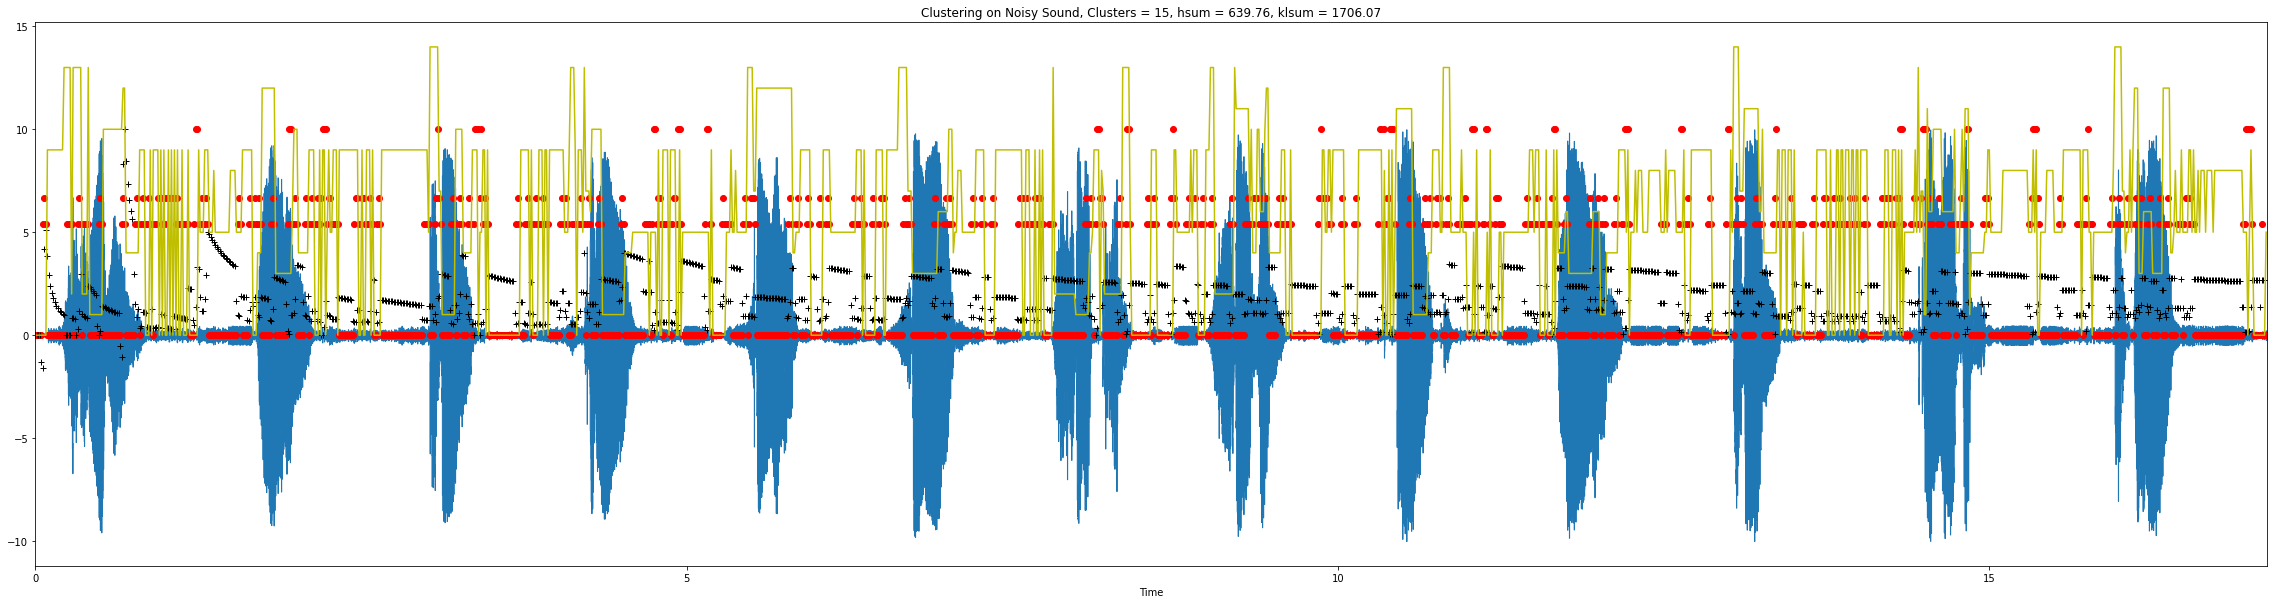

In [12]:
mel_spc2 = librosa.feature.melspectrogram(y=data2, sr=rate2, n_fft=2048, hop_length=h_step, win_length=h_window_size)
mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60) 
result2 = KMeans(n_clusters = numclust, random_state = 0).fit(mel_spc_db2.T)
#steps = stepper(result.labels_, 3)
steps = stepper(result2.labels_, rate = 16, step_size = 1, window_size = 4)
probs = prob_calc(steps, binNum = 12)
h2 = entropy_calc(probs)
kl2 = kl_calc(probs)

hsum = np.sum(h2)
klsum = np.sum(kl2)

plt.figure(figsize = (40,10))
plt.title("Clustering on Noisy Sound, Clusters = {}, hsum = {}, klsum = {}".format(numclust, np.round(hsum, 2), np.round(klsum, 2)))
librosa.display.waveshow(y = 10*data2/np.max(np.abs(data2)), sr = rate2)
plt.plot(np.arange(0,len(h2))/(rate2/h_step), 10*h2/np.max(h2), 'ro')
plt.plot(np.arange(0,len(kl2))/(rate2/h_step), 10*kl2/np.nanmax(np.abs(kl2)), 'k+')
plt.autoscale(enable=True, axis='x', tight=True)
plt.plot(np.arange(0,len(h2))/(rate2/h_step), result2.labels_, 'y')

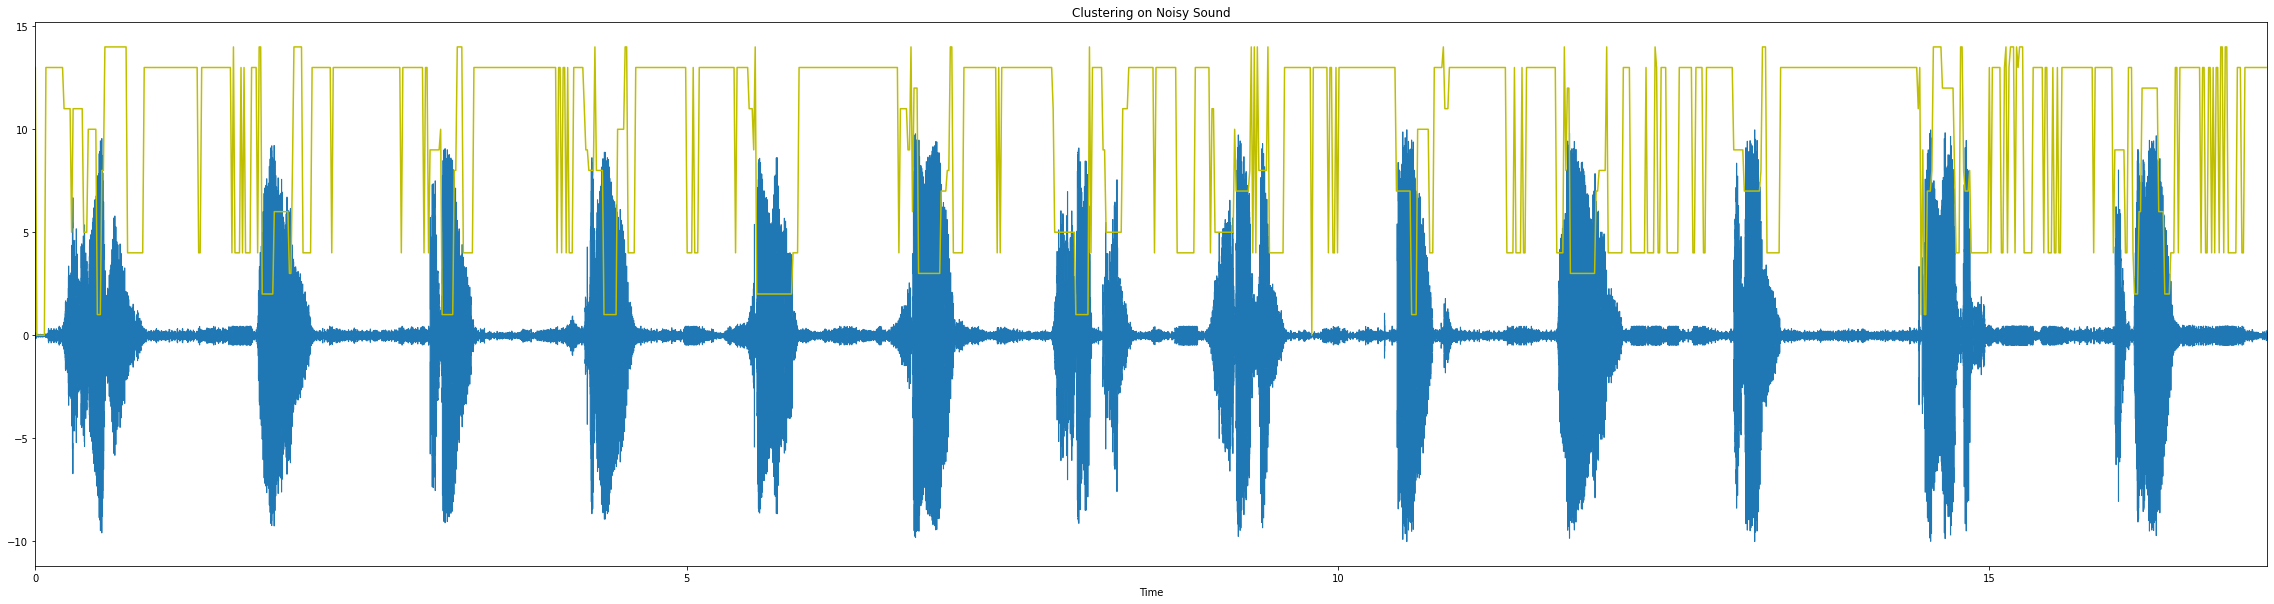

In [13]:
# predict
predict = result.predict(mel_spc_db2.T)
plt.figure(figsize = (40,10))
plt.title("Clustering on Noisy Sound")
librosa.display.waveshow(y = 10*data2/np.max(np.abs(data2)), sr = rate2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.plot(np.arange(0,len(h2))/(rate2/h_step), predict, 'y')

<a name = "heat" a></a>
## Heatmap based on Volume of Noise Added
[Top](#topp)

In [14]:
volume = np.arange(-60, 5, 5)

numclust = 15

mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=2048, hop_length=h_step, win_length=h_window_size) # clean data
mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60) 
result = KMeans(n_clusters = numclust, random_state = 0).fit(mel_spc_db.T) # clustering on clean sound

plabels = [result.labels_[0:1476]]
for i in volume:
    noiseMachine(numbers, i, export = True, name = "trial2.wav") # creates new audio file with the given volume 
    data2, rate2 = librosa.load("trial2.wav") # imports noisy audio file
    mel_spc2 = librosa.feature.melspectrogram(y=data2, sr=rate2, n_fft=2048, hop_length=h_step, win_length=h_window_size) 
    mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60)
    plabels.append(result.predict(mel_spc_db2.T)) # uses clustering from the clean sound to label noisy sound
        


C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\tanse\anaconda3\lib\site-

Text(339.0, 0.5, 'Volume')

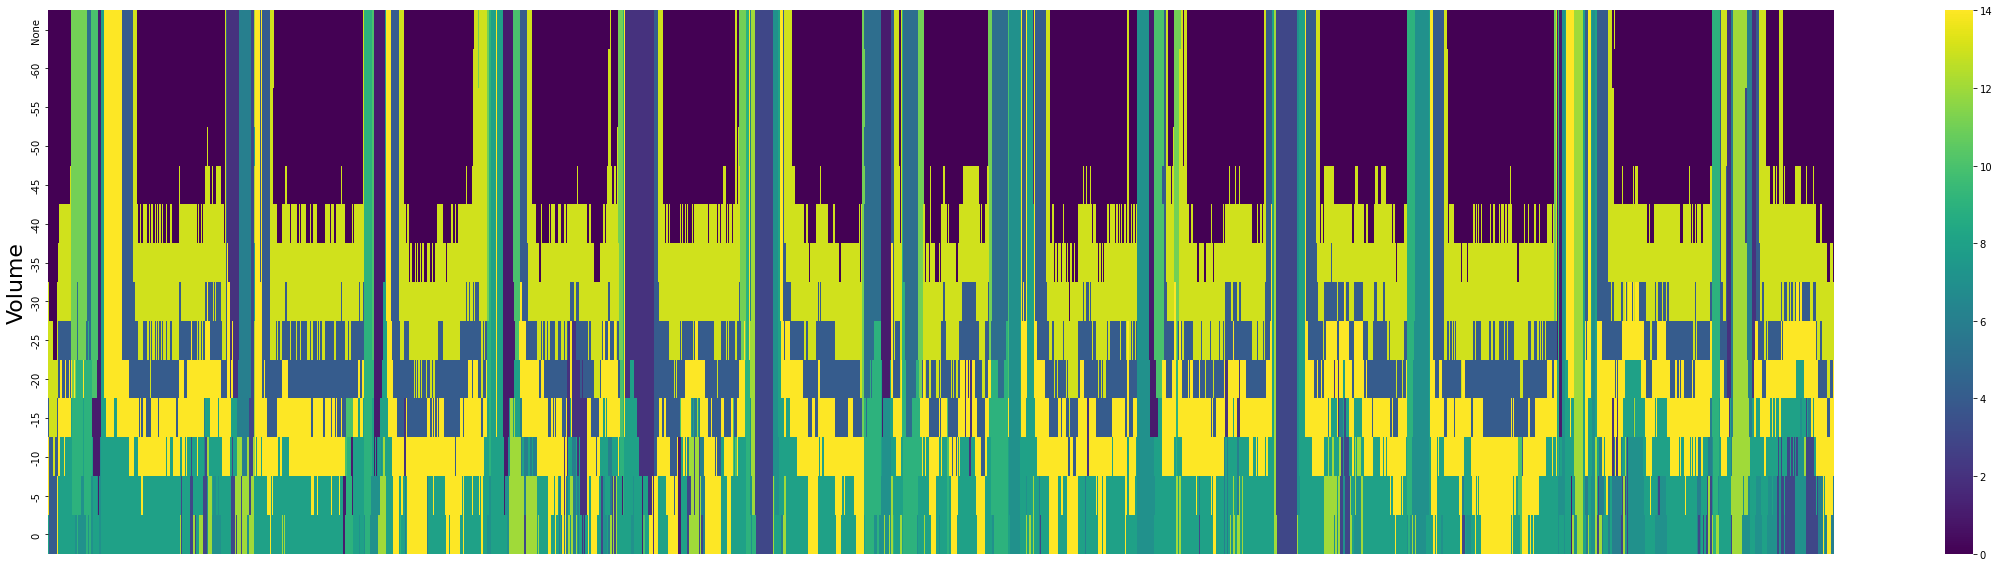

In [15]:
columns = ["None", -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0]
df = pd.DataFrame(np.row_stack(plabels), index = columns )
plt.figure(figsize = (40,10))
hmap = sns.heatmap(df, xticklabels = False, cmap = "viridis")
plt.ylabel("Volume", fontsize = 22)


<a name = "wordrec" a></a>
## Word Recognition
[Top](#topp)

In [16]:
def split0s(labs, ind = False, numclusts = 15):
    listy = []
    count = 0
    for i in range(0, len(labs)):
        if labs[i] == statistics.mode(labs): # 0 originally
            count += 1
            if count < 13:
                listy.append(i)
        else:
            count = 0
            listy.append(i)
    gb = groupby(enumerate(listy), key=lambda x: x[0] - x[1])
    all_groups = ([i[1] for i in g] for _, g in gb)
    indexes =  list(filter(lambda x: len(x) > 1, all_groups))[1:]
    if ind == True:
        return indexes
    lcodes = []
    for i in range(0, len(indexes)):
        lcodes.append(labs[indexes[i]])
    new_code =[]
    for j in lcodes:
        index = np.where(j != 0)
        temp = (j[0:np.max(index)])
        if len(temp) > 0:
            new_code.append(temp)
    return(new_code)

def filter_symbols(signal,code_words):
    ''' Convolves a signal (i.e. a series of symbols) with codewords constructed form the same symbols and looks for overlaps but ignores any numerical values'''
   
    N_code_words = np.shape(code_words)[0]
    filter_output = np.zeros([len(code_words),len(signal)])
    for cnt, jcode in enumerate(code_words):
        L_code = len(jcode)
        N_segments = len(signal) - len(jcode)
        for jseg in range(N_segments):
            segment = signal[(jseg + 0):(jseg + L_code)]
            match_count = 0
            for jind in range(L_code):
                if segment[jind] == jcode[jind]:
                    match_count += 1
            filter_output[cnt, jseg] = match_count/L_code # this is the fraction of matching symbols
           
    return filter_output

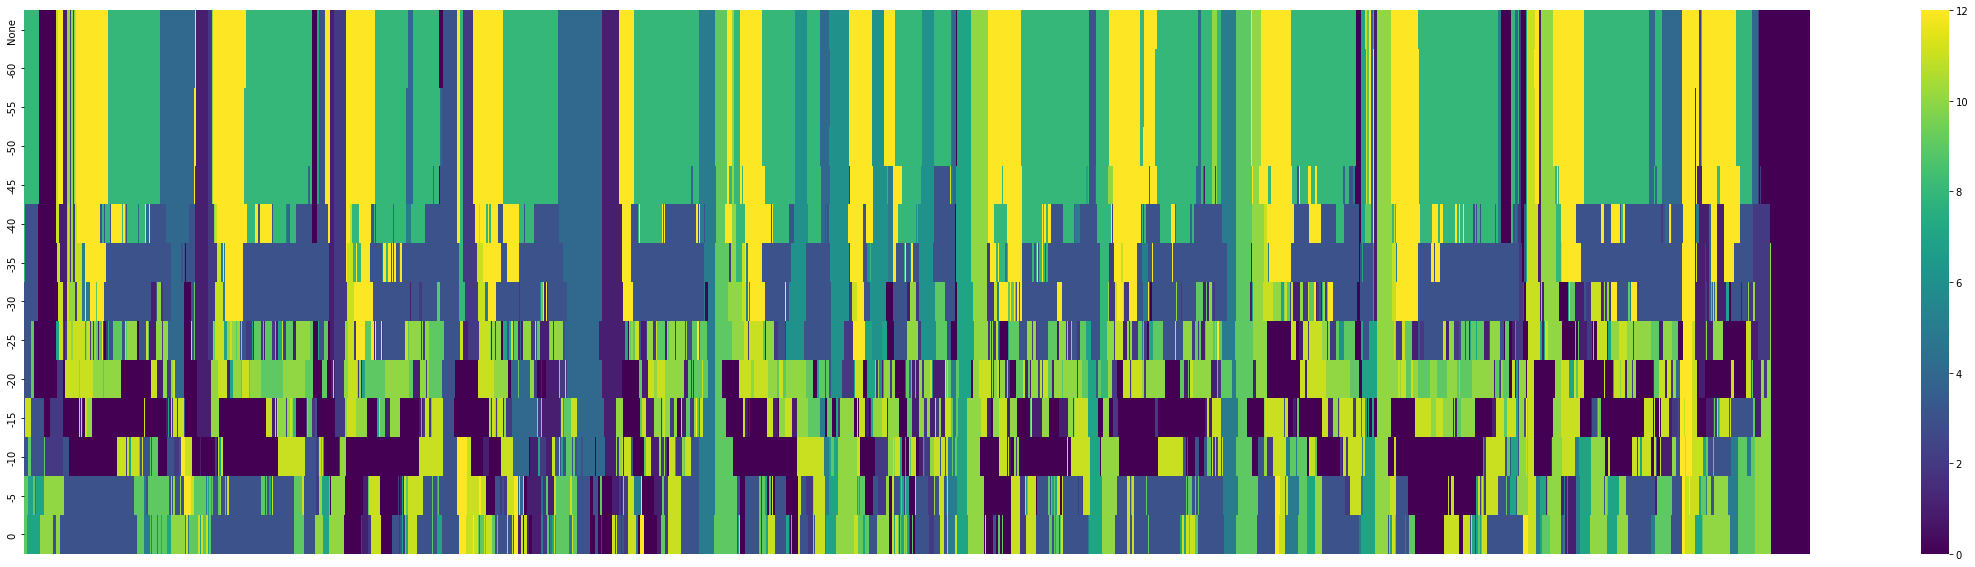

In [17]:
# heatmap

mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=2048, hop_length=h_step, win_length=h_window_size) # clean data
mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60) 
result = KMeans(n_clusters = numclust, random_state = 0).fit(mel_spc_db.T) 


new_code = split0s(result.labels_)

maxed = np.zeros((len(plabels), len(plabels[0])))
for i in range(0, len(plabels)):
    filter_output = filter_symbols(signal = plabels[i], code_words = new_code)
    for j in range(0, len(plabels[i])):
        maxed[i,j] = np.argmax(filter_output[:,j])
dfx = pd.DataFrame(maxed, index = columns)
    
plt.figure(figsize = (40,10))
hmap = sns.heatmap(dfx, xticklabels = False, cmap = "viridis")

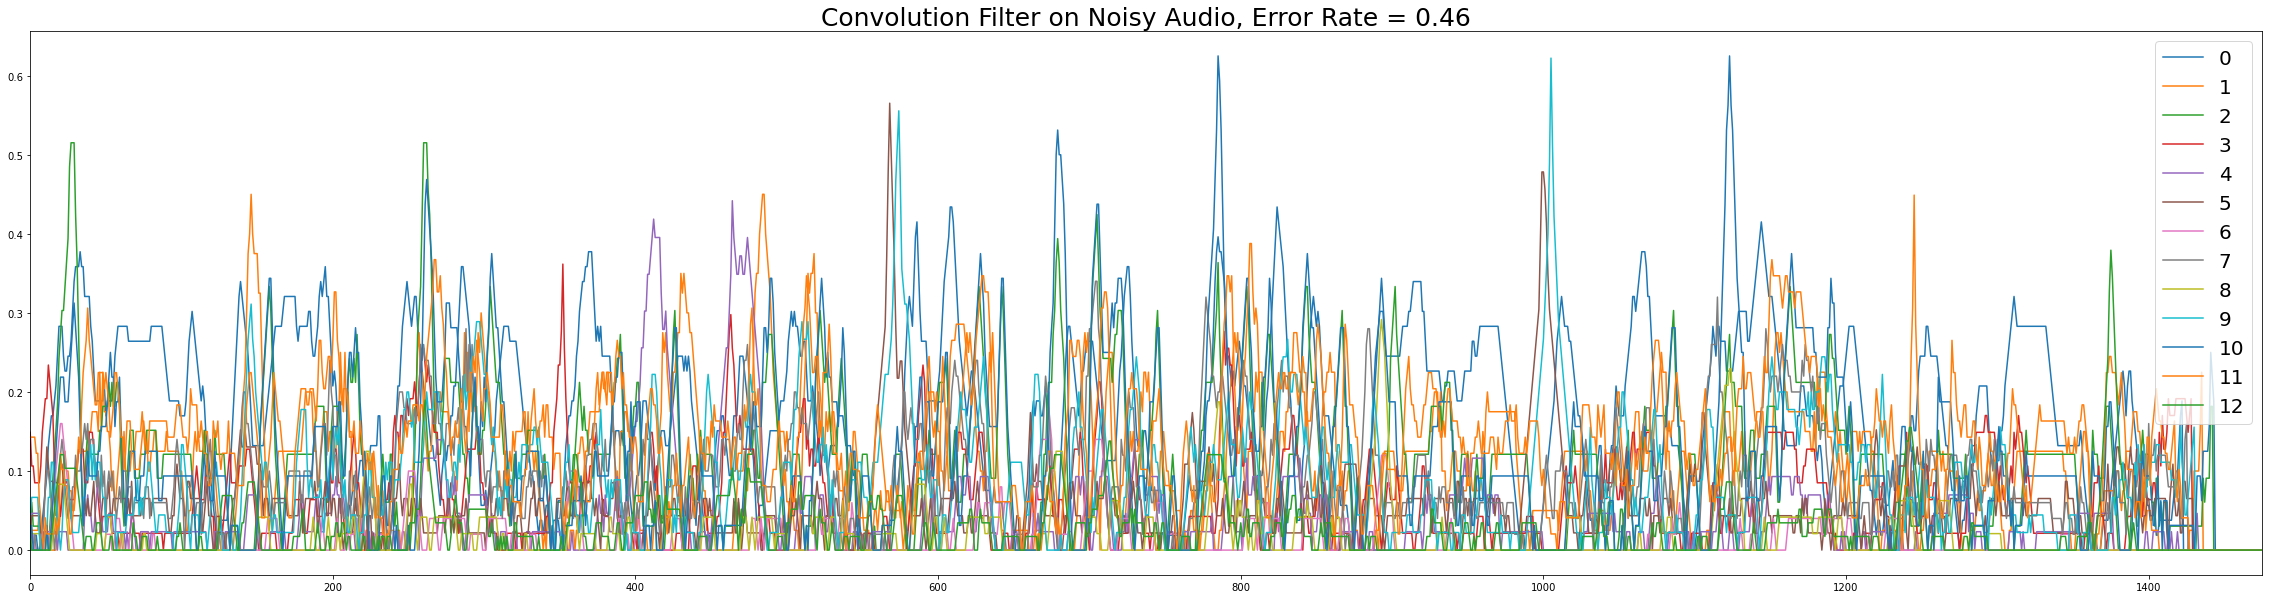

In [18]:
filter_output = filter_symbols(signal = plabels[10], code_words = new_code)
plt.figure(figsize = (40,10))
plt.autoscale(enable=True, axis='x', tight=True)
for cnt, code_word in enumerate(new_code):
    plt.plot(filter_output[cnt])
plt.title("Convolution Filter on Noisy Audio, Error Rate = 0.46", fontsize = 25)
plt.legend(np.arange(13), fontsize = 20)

In [19]:

def error_rate(resultLabels, new_code):
    ind = split0s(resultLabels, True)
    startstop = np.zeros((len(new_code), 2))
    for i in range(0, len(startstop)):
        startstop[i,:] = (np.min(ind[i]), np.max(ind[i]))
    success = np.zeros((len(plabels),len(new_code)))
    for k in range(0, len(plabels)):
        filter_output = filter_symbols(signal = plabels[k], code_words = new_code)
        for i in range(0, len(filter_output)):
            temp = np.zeros(len(filter_output))
            for j in range(0, len(filter_output)):
                temp[j] = np.max(filter_output[j,int(startstop[i,0]):int(startstop[i,1])])
            success[k,i] = 1 - (np.argmax(temp) == i) 
    return success



In [20]:
result = KMeans(n_clusters = 15, random_state = 0).fit(mel_spc_db.T) 
new_code = split0s(result.labels_)
erWord = error_rate(result.labels_, new_code)

Text(0, 0.5, 'Error Rate')

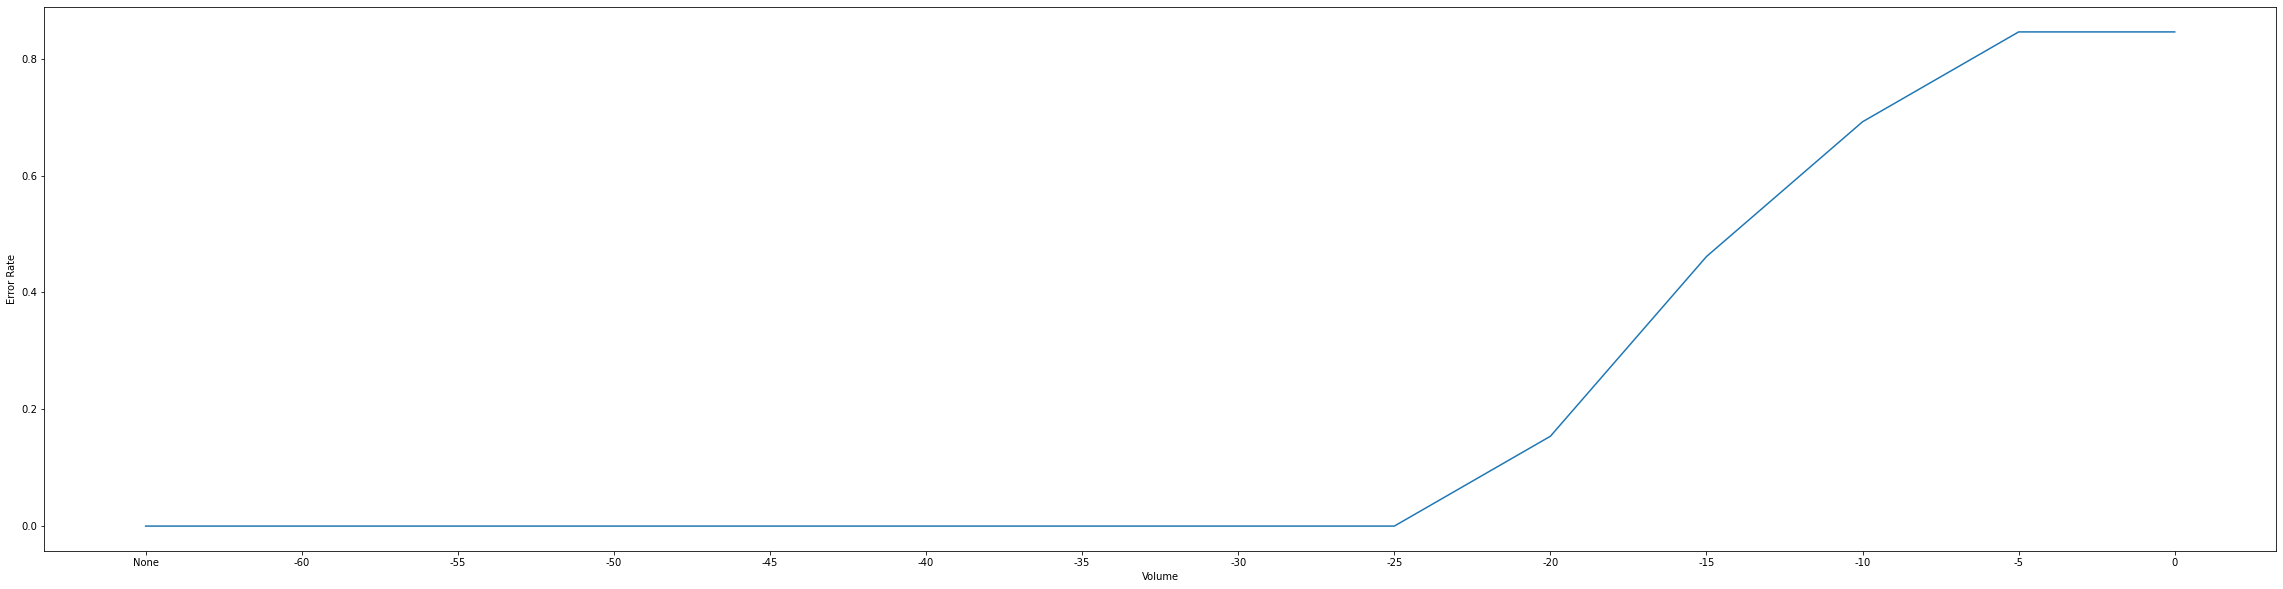

In [21]:
plt.figure(figsize = (40,10))
plt.plot(columns, np.average(erWord, axis = 1))
plt.xlabel("Volume")
plt.ylabel("Error Rate")


## Phoneme Recognition
- Hand labeling phonemes

In [22]:
phonemes = (3, 8, 10, 12, 13, 14, 15, 16, 17, 21, 26, 27, 28, 30, 32, 35, 42)

def phonecoder(labels, phonemes, file_name): # creates a function that will take the time of each phonemes, and automatically adjust for the length of the labels
    clustsec = len(labels) / librosa.get_duration(filename = file_name)
    listy = [[]] * 13
    listy[0] = [0.2, 0.4, 0.55, 0.65, 0.85]
    listy[1]  = [1.7, 1.95, 2.15]
    listy[2]  = [3.03, 3.12, 3.39]
    listy[3]  = [4.08, 4.25, 4.3, 4.65]
    listy[4]  = [5.35, 5.54, 5.87]
    listy[5]  = [6.55, 6.74, 7.05, 7.26]
    listy[6]  = [7.8, 7.99, 8.19, 8.45]
    listy[7]  = [8.99, 9.2, 9.38, 9.47, 9.64]
    listy[8]  = [10.44, 10.8, 10.97]
    listy[9]  = [11.67, 11.75, 12.06, 12.21]
    listy[10]  = [13.03, 13.13, 13.26, 13.44]
    listy[11]  = [14.46, 14.64, 14.79, 14.88, 15.03]
    listy[12]  = [15.95, 16.1, 16.24, 16.43, 16.66]
    listy2 = listy.copy()
    for i in range(0, len(listy)):
        for j in range(0, len(listy[i])):
            listy2[i][j] = int(np.floor(clustsec * listy[i][j]))
    phone_code = [labels[listy2[4][0]:listy2[4][1]], labels[listy2[5][0]: listy2[5][1]],          #labels[461:478], labels[565:581], # 3 f
                  labels[listy2[11][1]:listy2[11][2]], labels[listy2[12][2]:listy2[12][3]],  # labels[1263:1276], labels[1401:1418], # 8 l
                  labels[listy2[1][1]:listy2[1][2]], labels[listy2[7][3]:listy2[7][4]], labels[listy2[9][0]:listy2[9][1]], labels[listy2[9][2]:listy2[9][3]],
                  labels[listy2[10][2]:listy2[10][3]], labels[listy2[11][3]:listy[11][4]],
    #               labels[168:185], labels[817:832], labels[1007:1014], labels[1040:1053], labels[1144:1160], labels[1284:1297], # 10 n 
                  labels[listy2[0][2]:listy2[0][3]], labels[listy2[3][1]:listy2[3][2]], #labels[47:56], labels[366:371], # 12 r
                  labels[listy2[6][0]:listy2[6][1]], labels[listy2[0][1]:listy2[0][2]], #labels[673:689], labels[775:794], # 13 s
                  labels[listy2[2][0]:listy2[2][1]], labels[listy2[8][0]:listy2[8][1]], labels[listy2[10][0]:listy2[10][1]], labels[listy2[12][0]:listy2[12][1]],
    #               labels[261:269], labels[932:946], labels[1124:1133], labels[1376:1389], # 14 t
                  labels[listy2[5][2]:listy2[5][3]], labels[listy2[7][2]:listy2[7][3]], labels[listy2[11][2]:listy2[11][3]], labels[listy2[12][3]:listy2[12][4]], 
    #               labels[608:626], labels[809:817], labels[1276:1284], labels[1418:1438], # 15 v
                  labels[listy2[1][0]:listy2[1][1]], labels[listy2[12][1]:listy2[12][2]], #labels[146:168], labels[1389:1401], # 16 w
                  labels[listy2[0][0]:listy2[0][1]], #labels[17:34], # 17 z
                  labels[listy2[3][0]:listy2[3][1]], #labels[352:366], # 21 th
                  labels[listy2[8][0]:listy2[8][1]], #labels[901:932], # 26 ay
                  labels[listy2[0][1]:listy2[0][2]], labels[listy2[3][2]:listy2[3][3]], #labels[34:47], labels[371:401], # 28 ee
                  labels[listy2[5][1]:listy2[5][2]], labels[listy2[9][1]:listy2[9][2]], #labels[581:606], labels[1014:1040], # 30 eye
                  labels[listy2[0][3]:listy2[0][4]], #labels[56:73], # 32 o
                  labels[listy2[0][1]:listy2[0][2]], #labels[269:292], # 35 oo
                  labels[listy2[4][1]:listy2[4][2]] #labels[478:506] # 32 ore
                  ]
    phoneme_ind = [[listy2[4][0],listy2[4][1]], [listy2[5][0], listy2[5][1]],          #[461,478], [565,581], # 3 f
              [listy2[11][1],listy2[11][2]], [listy2[12][2],listy2[12][3]],  # [1263,1276], [1401,1418], # 8 l
              [listy2[1][1],listy2[1][2]], [listy2[7][3],listy2[7][4]], [listy2[9][0],listy2[9][1]], [listy2[9][2],listy2[9][3]],
              [listy2[10][2],listy2[10][3]], [listy2[11][3],listy[11][4]],
    #               [168,185], [817,832], [1007,1014], [1040,1053], [1144,1160], [1284,1297], # 10 n 
              [listy2[0][2],listy2[0][3]], [listy2[3][1],listy2[3][2]], #[47,56], [366,371], # 12 r
              [listy2[6][0],listy2[6][1]], [listy2[0][1],listy2[0][2]], #[673,689], [775,794], # 13 s
              [listy2[2][0],listy2[2][1]], [listy2[8][0],listy2[8][1]], [listy2[10][0],listy2[10][1]], [listy2[12][0],listy2[12][1]],
    #               [261,269], [932,946], [1124,1133], [1376,1389], # 14 t
              [listy2[5][2],listy2[5][3]], [listy2[7][2],listy2[7][3]], [listy2[11][2],listy2[11][3]], [listy2[12][3],listy2[12][4]], 
    #               [608,626], [809,817], [1276,1284], [1418,1438], # 15 v
              [listy2[1][0],listy2[1][1]], [listy2[12][1],listy2[12][2]], #[146,168], [1389,1401], # 16 w
              [listy2[0][0],listy2[0][1]], #[17,34], # 17 z
              [listy2[3][0],listy2[3][1]], #[352,366], # 21 th
              [listy2[8][0],listy2[8][1]], #[901,932], # 26 ay
              [listy2[0][1],listy2[0][2]], [listy2[3][2],listy2[3][3]], #[34,47], [371,401], # 28 ee
              [listy2[5][1],listy2[5][2]], [listy2[9][1],listy2[9][2]], #[581,606], [1014,1040], # 30 eye
              [listy2[0][3],listy2[0][4]], #[56,73], # 32 o
              [listy2[0][1],listy2[0][2]], #[269,292], # 35 oo
              [listy2[4][1],listy2[4][2]] #[478,506] # 32 ore
              ]
    return phone_code, phoneme_ind



In [23]:
phone_code, phoneme_ind = phonecoder(plabels[0], phonemes, "trial2.wav")
filter_output = filter_symbols(signal = plabels[0], code_words = phone_code)

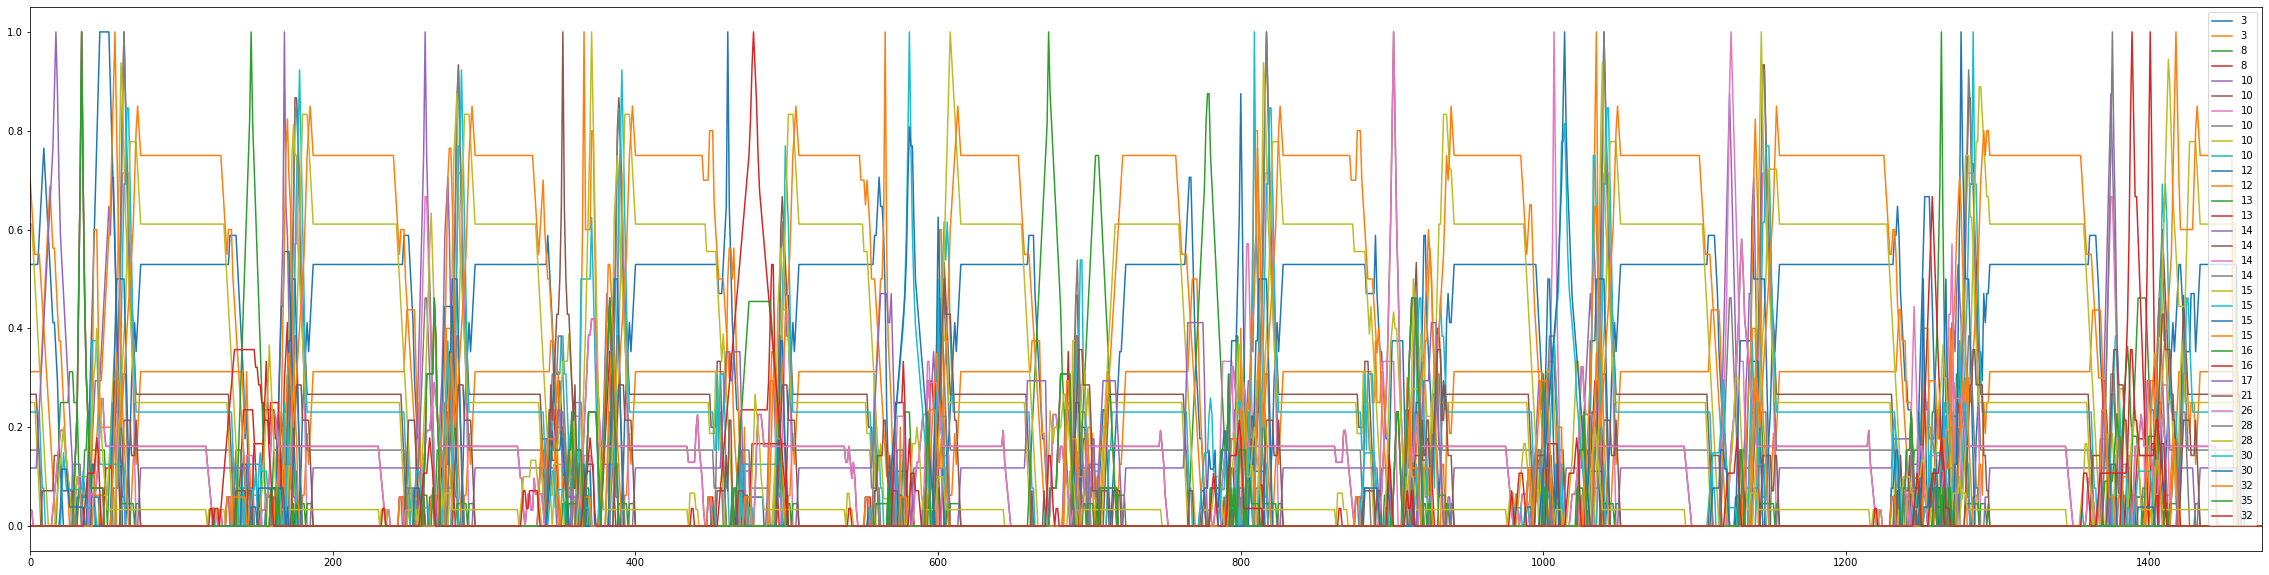

In [24]:
codewordlabels = [3, 3, 8, 8, 10, 10, 10, 10, 10, 10, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 17, 21, 26, 28, 28, 30, 30, 32, 35, 32]
colors = plt.cm.jet(np.linspace(0,1,len([3, 3, 8, 8, 10, 10, 10, 10, 10, 10, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 17, 21, 26, 28, 28, 30, 30, 32, 35, 32])))

plt.figure(figsize = (40,10))
plt.autoscale(enable=True, axis='x', tight=True)
for cnt, code_word in enumerate(phone_code):
    plt.plot(filter_output[cnt])
plt.legend([3, 3, 8, 8, 10, 10, 10, 10, 10, 10, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 17, 21, 26, 28, 28, 30, 30, 32, 35, 32])



In [25]:
filter_output = filter_symbols(signal = plabels[10], code_words = phone_code)
final = np.zeros(len(filter_output))
for i in range(0, len(filter_output)):
    temp = np.zeros(len(filter_output))
    for j in range(0, len(filter_output)):
        temp[j] = np.max(filter_output[j, phoneme_ind[i][0]: phoneme_ind[i][1]])
    final[i] = i in (np.argwhere(temp == np.amax(temp)))


In [26]:
# for all levels of noise
phone_error = np.zeros(len(plabels))
for k in range(0, len(plabels)):
    filter_output = filter_symbols(signal = plabels[k], code_words = phone_code)
    final = np.zeros(len(filter_output))
    for i in range(0, len(filter_output)):
        temp = np.zeros(len(filter_output))
        for j in range(0, len(filter_output)):
            temp[j] = np.max(filter_output[j, phoneme_ind[i][0]: phoneme_ind[i][1]])
        final[i] = i in (np.argwhere(temp == np.amax(temp)))
    phone_error[k] = 1 - np.average(final)


In [27]:

resultj = KMeans(n_clusters = 15, random_state = 0).fit(mel_spc_db.T)
plabelj = resultj.predict(mel_spc_db2.T)
labelError = np.zeros(len(plabels))
for i in range(0,len(plabels)):
    labelError[i] = 1 - np.mean(plabels[0] == plabels[i])



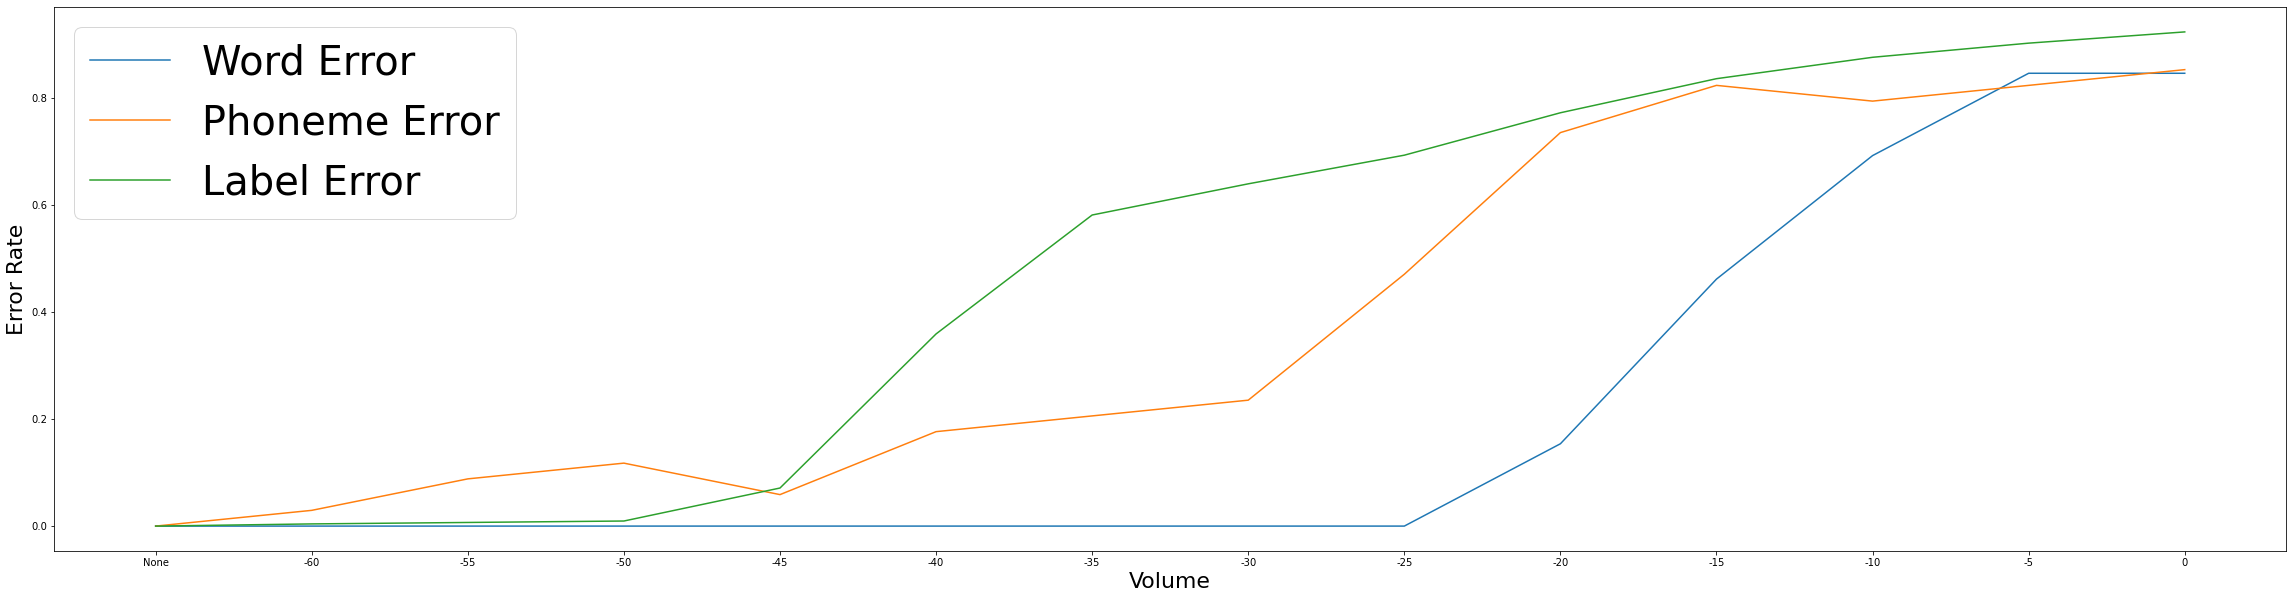

In [28]:
plt.figure(figsize = (40,10))
plt.plot(columns, np.average(erWord, axis = 1))
plt.plot(columns, phone_error)
plt.plot(columns, labelError)
plt.xlabel("Volume", fontsize = 22)
plt.ylabel("Error Rate", fontsize = 22)
plt.legend(["Word Error", "Phoneme Error", "Label Error"], fontsize = 40)


## Error Bit Rate Graph

In [29]:
# mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=2048, hop_length=h_step, win_length=h_window_size)
# mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60)

noiseMachine(numbers, -15, export = True, name = "trial2.wav") # creates new audio file with the given volume 
data2, rate2 = librosa.load("trial2.wav") # imports noisy audio file

# mel_spc2 = librosa.feature.melspectrogram(y=data2, sr=rate2, n_fft=2048, hop_length=h_step, win_length=h_window_size) 
# mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60)

C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [30]:
 # volume = -15

errorList = []
brList = []
colorList = []
nfftstep = [1024, 2048, 4096, 8192]
hstep =   [128, 128, 128,  256, 256, 512]
hwindow = [256, 512, 1024, 512, 1024, 1024]
listclusts = [3,5,7,9,11,13,15,17,19,21,23,25]
#listclusts = [3,5,10,15,20,25,30]
#listclusts = range(3,25)
for t in range(0, len(nfftstep)):
    for h in range(0, len(hstep)):
        mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=nfftstep[t], hop_length=hstep[h], win_length=hwindow[h])
        mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60)

        mel_spc2 = librosa.feature.melspectrogram(y=data2, sr=rate2, n_fft=nfftstep[t], hop_length=hstep[h], win_length=hwindow[h]) 
        mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60)

        for i in range(0, len(listclusts)):
            resulti = KMeans(n_clusters = listclusts[i], random_state = 0).fit(mel_spc_db.T)
            new_code = split0s(resulti.labels_, numclusts = listclusts[i])
            plabel = resulti.predict(mel_spc_db2.T)
            ind = split0s(resulti.labels_, True)
            startstop = np.zeros((len(new_code), 2))
            success = np.zeros(len(new_code))
            for j in range(0, len(startstop)):
                startstop[j,:] = (np.min(ind[j]), np.max(ind[j]))
            filter_output = filter_symbols(signal = plabel, code_words = new_code)
            for k in range(0, len(filter_output)):
                temp = np.zeros(len(filter_output))
                for l in range(0, len(filter_output)):
                    temp[l] = np.max(filter_output[l,int(startstop[k,0]):int(startstop[k,1])])
                success[k] = 1 - (np.argmax(temp) == k)
            totalLen = []
            sliceTime = librosa.get_duration(filename = "trial2.wav") / len(plabel)
            for j in new_code:
                totalLen.append(len(j))
            avgTime = np.mean(totalLen) * sliceTime
            brList.append(len(new_code)/avgTime)
            errorList.append(np.average(success))
            colorList.append("Words")
            
            phone_codei, phoneme_indi = phonecoder(resulti.labels_, phonemes, "trial2.wav")
            filter_outputi = filter_symbols(signal = plabel, code_words = phone_codei)
            final = np.zeros(len(filter_outputi))
            for j in range(0, len(filter_outputi)):
                temp = np.zeros(len(filter_outputi))
                for k in range(0, len(filter_outputi)):
                    temp[k] = np.max(filter_outputi[k, phoneme_indi[j][0]: phoneme_indi[j][1]])
                final[j] = j in (np.argwhere(temp == np.amax(temp)))
            errorList.append(1-np.average(final))
            totalLen = []
            for m in phone_codei:
                totalLen.append(len(m))
            sliceTime = librosa.get_duration(filename = "trial2.wav") / len(plabel)
            avgTime = np.mean(totalLen) * sliceTime
            brList.append(len(phone_codei)/avgTime)
            colorList.append("Phonemes")   

            sliceTime = librosa.get_duration(filename = "trial2.wav") / len(plabel)
            errorList.append(1-np.average(resulti.labels_[:-1] == plabel))
            brList.append(len(plabel)/sliceTime)
            colorList.append("Labels")
            

Text(0.5, 1.0, 'Bit Error Rate, NoiseVol = -15')

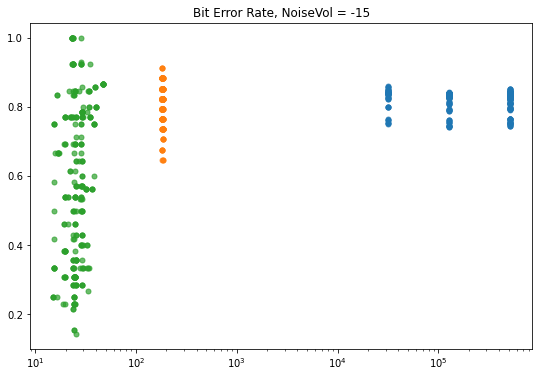

In [31]:
df1 = pd.DataFrame({"bitRate": brList, "errorRate": errorList, "method": colorList})
fig, ax = plt.subplots(figsize = (9, 6))
groups = df1.groupby('method')
for name, group in groups:
    ax.plot(group.bitRate, group.errorRate, marker='o', linestyle='', markersize=5, label=name, alpha = 0.7)
ax.set_xscale("log");
ax.set_title("Bit Error Rate, NoiseVol = -15")


### Changing Volume

In [32]:
noiseMachine(numbers, -5, export = True, name = "trial3.wav") # creates new audio file with the given volume 
data3, rate3 = librosa.load("trial3.wav") # imports noisy audio file

C:\Users\tanse\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [ ]:
 # volume = -5

errorListQ = []
brListQ = []
colorListQ = []
nfftstep = [1024, 2048, 4096, 8192]
hstep =   [128, 128, 128,  256, 256, 512]
hwindow = [256, 512, 1024, 512, 1024, 1024]
listclusts = [3,5,7,9,11,13,15,17,19,21,23,25]
#listclusts = [3,5,10,15,20,25,30]
#listclusts = range(3,25)
for t in range(0, len(nfftstep)):
    for h in range(0, len(hstep)):
        mel_spc = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=nfftstep[t], hop_length=hstep[h], win_length=hwindow[h])
        mel_spc_db = librosa.power_to_db(mel_spc, ref = np.max, top_db = 60)

        mel_spc2 = librosa.feature.melspectrogram(y=data3, sr=rate3, n_fft=nfftstep[t], hop_length=hstep[h], win_length=hwindow[h]) 
        mel_spc_db2 = librosa.power_to_db(mel_spc2, ref = np.max, top_db = 60)

        for i in range(0, len(listclusts)):
            resulti = KMeans(n_clusters = listclusts[i], random_state = 0).fit(mel_spc_db.T)
            new_code = split0s(resulti.labels_, numclusts = listclusts[i])
            plabel = resulti.predict(mel_spc_db2.T)
            ind = split0s(resulti.labels_, True)
            startstop = np.zeros((len(new_code), 2))
            success = np.zeros(len(new_code))
            for j in range(0, len(startstop)):
                startstop[j,:] = (np.min(ind[j]), np.max(ind[j]))
            filter_output = filter_symbols(signal = plabel, code_words = new_code)
            for k in range(0, len(filter_output)):
                temp = np.zeros(len(filter_output))
                for l in range(0, len(filter_output)):
                    temp[l] = np.max(filter_output[l,int(startstop[k,0]):int(startstop[k,1])])
                success[k] = 1 - (np.argmax(temp) == k)
            totalLen = []
            sliceTime = librosa.get_duration(filename = "trial3.wav") / len(plabel)
            for j in new_code:
                totalLen.append(len(j))
            avgTime = np.mean(totalLen) * sliceTime
            brListQ.append(len(new_code)/avgTime)
            errorListQ.append(np.average(success))
            colorListQ.append("Words")
            
            phone_codei, phoneme_indi = phonecoder(resulti.labels_, phonemes, "trial3.wav")
            filter_outputi = filter_symbols(signal = plabel, code_words = phone_codei)
            final = np.zeros(len(filter_outputi))
            for j in range(0, len(filter_outputi)):
                temp = np.zeros(len(filter_outputi))
                for k in range(0, len(filter_outputi)):
                    temp[k] = np.max(filter_outputi[k, phoneme_indi[j][0]: phoneme_indi[j][1]])
                final[j] = j in (np.argwhere(temp == np.amax(temp)))
            errorListQ.append(1-np.average(final))
            totalLen = []
            for m in phone_codei:
                totalLen.append(len(m))
            sliceTime = librosa.get_duration(filename = "trial3.wav") / len(plabel)
            avgTime = np.mean(totalLen) * sliceTime
            brListQ.append(len(phone_codei)/avgTime)
            colorListQ.append("Phonemes")   

            sliceTime = librosa.get_duration(filename = "trial3.wav") / len(plabel)
            errorListQ.append(1-np.average(resulti.labels_[:-1] == plabel))
            brListQ.append(len(plabel)/sliceTime)
            colorListQ.append("Labels")
            

In [ ]:
df2 = pd.DataFrame({"bitRate": brListQ, "errorRate": errorListQ, "method": colorList})
fig, ax = plt.subplots(figsize = (9, 6))
groups2 = df2.groupby('method')
for name, group in groups2:
    ax.plot(group.bitRate, group.errorRate, marker='o', linestyle='', markersize=5, label=name, alpha = 0.7)
ax.set_xscale("log");
ax.set_title("Bit Error Rate, NoiseVol = -5")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharey = True)
df1 = pd.DataFrame({"bitRate": brList, "errorRate": errorList, "method": colorList})
groups = df1.groupby('method')
for name, group in groups:
    ax[0].plot(group.bitRate, group.errorRate, marker='o', linestyle='', markersize=5, label=name, alpha = 0.7)
ax[0].set_xscale("log");
ax[0].legend(loc = "lower right")
ax[0].set_title("Bit Error Rate, NoiseVol = -15")

df2 = pd.DataFrame({"bitRate": brListQ, "errorRate": errorListQ, "method": colorList})
groups2 = df2.groupby('method')
for name, group in groups2:
    ax[1].plot(group.bitRate, group.errorRate, marker='o', linestyle='', markersize=5, label=name, alpha = 0.7)
ax[1].set_xscale("log");
ax[1].legend(loc = "lower right")
ax[1].set_title("Bit Error Rate, NoiseVol = -5")
